In [1]:
library(limma)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
load("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi/data/psi_meta.Rdata")
load("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi/data/QC_metric.Rdata")

In [14]:
Sys.setenv(psi_fig_tables_RData_dir="/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/fig_tables/RData")

In [3]:
dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi"
setwd(dir)
#only use rows and cols in psi_reordered
inc0 <- read.csv("all.target_gene_inc.pasted.added_gene_symbols", header=T, row.names=1, sep="\t", check.names=F)
inc0 <- inc0[rownames(psi_reordered), colnames(psi_reordered)]

exc0 <- read.csv("all.target_gene_exc.pasted.added_gene_symbols", header=T, row.names=1, sep="\t", check.names=F)
exc0 <- exc0[rownames(psi_reordered), colnames(psi_reordered)]

In [5]:
selected_samples0 <- meta %>% filter((tissue == "skeletal_muscle" | tissue == "heart") & disease == "normal") %>% rownames() 
selected_samples <- intersect(rownames(metric), selected_samples0)
selected_meta <- meta[selected_samples,]

In [6]:
selected_inc <- inc0[,selected_samples]
selected_exc <- exc0[,selected_samples]

In [7]:
selected_metric <- metric[selected_samples,]

In [ ]:
design.matrix <- model.matrix(~group+tissue+age_group, data = selected_meta)

In [ ]:

inc.adj <- removeBatchEffect(log2(selected_inc + 1), 
                  covariates=selected_metric$Intronic.Rate,
                  design=design.matrix,
                  method="ls"          
                            )

In [ ]:

exc.adj <- removeBatchEffect(log2(selected_exc + 1), 
                  covariates=selected_metric$Intronic.Rate, 
                  method="ls",
                  design=design.matrix,
                            )

In [11]:
psi.adj <- 2^inc.adj/(2^inc.adj + 2^exc.adj)

In [12]:
selected_psi <- psi_reordered[, selected_samples]
diff <- as.vector(as.matrix(psi.adj - selected_psi))

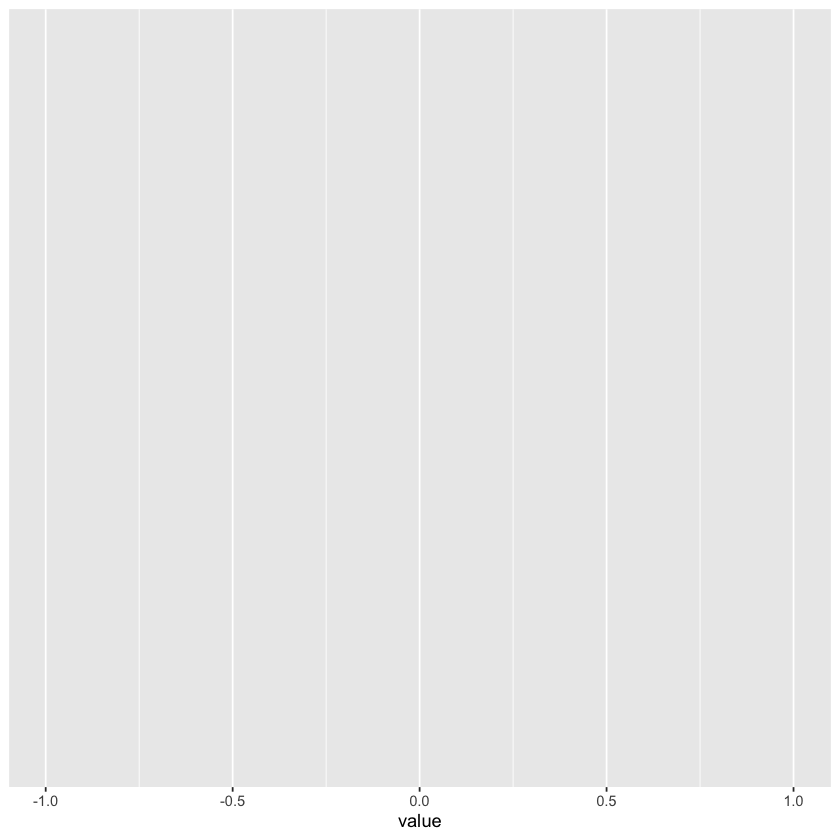

In [ ]:
# Convert the vector to a data frame
diff_df <- data.frame(value = diff)

# Create the histogram
g <- ggplot(diff_df, aes(x = value)) 


# print the plot
print(g)
Delta_PSI_adjusted_vs_original <- g
# save the plot in a RData file
save(Delta_PSI_adjusted_vs_original, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/Delta_PSI_adjusted_vs_original.RData"))

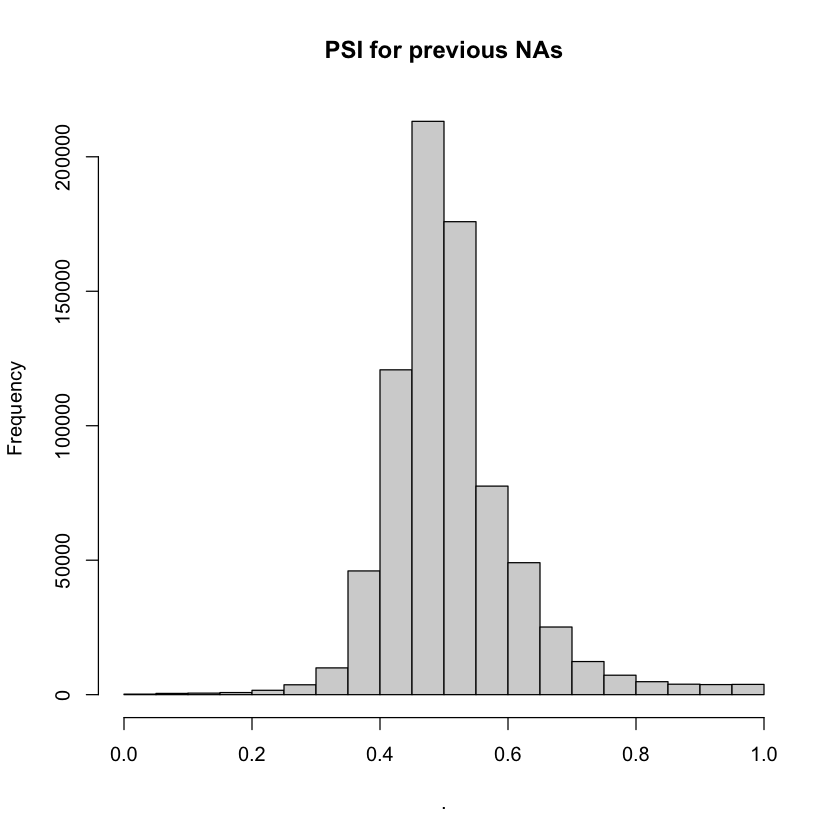

In [16]:
as.vector(as.matrix(psi.adj[is.na(selected_psi)])) %>% hist(main="PSI for previous NAs")

In [17]:
outliers <- c("GTEX-ZQUD-1726-SM-7P8ON", "5679sTS.Human.Heart.10w.Female")
outliers_romved_samples <- rownames(selected_meta)[!rownames(selected_meta) %in% outliers]

In [18]:
psi_reordered_noNA <- psi.adj 
psi_reordered <- psi.adj
psi_reordered[is.na(selected_psi)] <- NA
meta <- selected_meta[outliers_romved_samples, ]
psi_reordered <- psi_reordered[, outliers_romved_samples]
selected_metric <- selected_metric[outliers_romved_samples, ]

In [ ]:
save(psi, psi_reordered, meta, selected_metric, file = "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi_IRcorrected/data/psi_meta.Rdata")

In [20]:
covariates=selected_metric$Intronic.Rate
covariates <- as.matrix(covariates)

In [21]:
batch = NULL
batch2 = NULL
X.batch <- cbind(batch, batch2, covariates)
x = log2(selected_inc[, outliers_romved_samples] + 1)
design=design.matrix
design = matrix(1, ncol(x), 1)

In [ ]:

fit <- lmFit(x, cbind(design, X.batch))

beta <- fit$coefficients[, -(1:ncol(design)), drop = FALSE]

In [23]:
#check the overall contribution of each factor in TTN
fit$coefficients[grepl("TTN", rownames(fit$coefficients)),] %>% summary()

       x1                x2        
 Min.   :-0.1353   Min.   :-9.844  
 1st Qu.: 4.2945   1st Qu.: 9.576  
 Median : 5.2044   Median :12.641  
 Mean   : 5.6865   Mean   :11.386  
 3rd Qu.: 6.3287   3rd Qu.:15.399  
 Max.   :18.6466   Max.   :17.793  

In [24]:
#check the overall contribution of each factor in all NMD genes
fit$coefficients %>% summary()

       x1                x2         
 Min.   :-0.6087   Min.   :-26.029  
 1st Qu.: 3.0743   1st Qu.: -6.250  
 Median : 5.6144   Median : -2.201  
 Mean   : 5.6708   Mean   : -2.095  
 3rd Qu.: 7.9581   3rd Qu.:  2.037  
 Max.   :19.7071   Max.   : 18.626  

In [25]:
#see the scale of batch effect (Intronic rate), so it is effect should be the coefficient * the value here
X.batch %>% summary()

       V1         
 Min.   :0.02568  
 1st Qu.:0.06139  
 Median :0.07050  
 Mean   :0.08253  
 3rd Qu.:0.08541  
 Max.   :0.56239  